In [1]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import numpy as np
import tqdm
import cv2
from scipy.ndimage import label
from skimage.color import rgb2lab

In [3]:
# устраяем разрывы в суперпикселях, соединяя маленькие
# компоненты с соседями
def enforce_connectivity(labels, min_size_ratio):
    h, w = labels.shape
    total_pixels = h * w
    
    new_labels = labels.copy()
    unique_labels = np.unique(labels)
    K = len(unique_labels)
    avg_size = total_pixels / float(K)
    # вычисляем средний размер суперпикселя и определяем порог
    #для "маленьких" компонентов)
    min_size = int(avg_size * min_size_ratio)

    for cluster_label in tqdm.tqdm(unique_labels):
        mask = new_labels == cluster_label

        if np.any(mask):
            #определяет связные компоненты в маске.
            components, num_components = label(mask)

            for comp_id in range(1, num_components+1):
                component_mask = (components == comp_id)
                component_size = np.sum(component_mask)

                if component_size < min_size:
                    neighbors = []
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        shifted = np.roll(component_mask, shift=(dx, dy), axis=(0, 1))
                        neighbor_pixels = new_labels[shifted & ~component_mask]
                        neighbors.extend(neighbor_pixels)

                    neighbors = [n for n in neighbors if n != cluster_label]
                    if len(neighbors) > 0:
                        new_label = max(neighbors, key=neighbors.count)
                        new_labels[component_mask] = new_label

    return new_labels

In [11]:
def slic_superpixels_vectorized(image, K, m=10, max_iter=10, min_size_ratio=0.1):
    image = img_as_float(image)
    lab_image = rgb2lab(image) # L a b светлоты отделено от значения хроматической составляющей цвета (тон, насыщенность).
    h, w, _ = image.shape
    n_pixels = h * w
    # интервал сетки для центров суперпикселей
    S = int(np.sqrt(n_pixels / K))
    # регулярная сетка
    grid_y, grid_x = np.meshgrid(np.arange(S // 2, h, S), np.arange(S // 2, w, S), indexing='ij')
    grid_y = grid_y.ravel()
    grid_x = grid_x.ravel()
    centers = np.stack((lab_image[grid_y, grid_x, 0], # L
                        lab_image[grid_y, grid_x, 1], # a
                        lab_image[grid_y, grid_x, 2], # b
                        grid_x, # x
                        grid_y), axis=1) # y
    num_centers = centers.shape[0] # количество центров суперпикселей
    print(num_centers)
    labels = -np.ones((h, w), dtype=int)
    distances = np.full((h, w), np.inf)

    pixel_x, pixel_y = np.meshgrid(np.arange(w), np.arange(h)) # сетка координат

    for iteration in tqdm.tqdm(range(max_iter)):
        for k in range(num_centers):
            l, a, b, xk, yk = centers[k]

            # локальная зона поиска вокруг центра (2S x 2S)
            x_min, x_max = max(0, int(xk - S)), min(w, int(xk + S))
            y_min, y_max = max(0, int(yk - S)), min(h, int(yk + S))

            region_x = pixel_x[y_min:y_max, x_min:x_max]
            region_y = pixel_y[y_min:y_max, x_min:x_max]
            region_lab = lab_image[y_min:y_max, x_min:x_max]

            d_lab = np.sqrt((l - region_lab[..., 0]) ** 2 +
                            (a - region_lab[..., 1]) ** 2 +
                            (b - region_lab[..., 2]) ** 2)
            d_xy = np.sqrt((xk - region_x) ** 2 + (yk - region_y) ** 2) / S
            d_s = d_lab + m * d_xy

            # обновляем метки и расстояния для пикселей, если расстояние меньше текущего
            mask = d_s < distances[y_min:y_max, x_min:x_max]
            distances[y_min:y_max, x_min:x_max][mask] = d_s[mask]
            labels[y_min:y_max, x_min:x_max][mask] = k

        new_centers = np.zeros_like(centers)
        counts = np.zeros(num_centers, dtype=int)
        
        # преобразуем массивы меток и пикселей в одномерные массивы
        flat_labels = labels.ravel()
        flat_lab = lab_image.reshape(-1, 3)
        flat_pixel_coords = np.stack((pixel_x.ravel(), pixel_y.ravel()), axis=1)

        # пересчитываем каждый центр суперпикселя 
        for k in range(num_centers):
            mask = flat_labels == k # пиксели текущего суперпикселя
            if np.any(mask):
                new_centers[k, :3] = flat_lab[mask].mean(axis=0) # новые цветовые компоненты как среднее 
                new_centers[k, 3:] = flat_pixel_coords[mask].mean(axis=0) # -||- для пространственных 
                counts[k] = mask.sum()

        # на сколько смещать центры между итерациями 
        shift = np.sqrt(np.sum((centers - new_centers) ** 2))
        centers = new_centers
        if shift < 1e-4:
            break

    labels = enforce_connectivity(labels, min_size_ratio)

    return labels

In [13]:
image = cv2.imread('Landscape-Color.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

num_superpixels = 256
m = 20
labels = slic_superpixels_vectorized(image, num_superpixels, m)

250


100%|██████████| 250/250 [01:41<00:00,  2.47it/s]


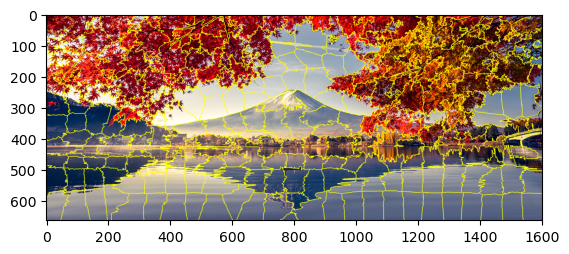

In [8]:
plt.imshow(mark_boundaries(image=image, label_img=labels))